In [3]:
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
from pprint import pprint

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [12]:
os.chdir("/Users/sabnig/Documents/Projects/Aging")

aging = pd.read_csv('Data/completeagedb6.csv')
ellipsefit = pd.read_csv('Data/ellipsefit_all.csv')
rearpaw = pd.read_csv('Data/rearpaw.csv')
var_agingall = pd.read_csv('Data/var_agingall.csv')

frailty_parameters = ['Alopecia','Loss of fur colour','Dermatitis','Loss of whiskers','Coat condition',
	'Piloerection','Cataracts','Eye discharge/swelling','Microphthalmia','Corneal opacity','Nasal discharge',
	'Rectal prolapse','Vaginal/uterine/','Diarrhea','Vestibular disturbance','Vision loss (Visual Placing)',
	'Menace reflex','Tail stiffening','Gait disorders','Tremor','Tumours','Distended abdomen','Kyphosis',
	'Body condition','Breathing rate/depth','Malocclusions','Righting Reflex']
avg_gait_measures_linear = ['avg_angular_velocity','avg_base_tail_lateral_displacement',
	'avg_limb_duty_factor','avg_nose_lateral_displacement','avg_speed_cm_per_sec',
	'avg_step_length1','avg_step_length2','avg_step_width','avg_stride_length','avg_temporal_symmetry',
	'avg_tip_tail_lateral_displacement']
avg_gait_measures_circular = ['avg_base_tail_lateral_displacement_phase','avg_nose_lateral_displacement_phase',
'avg_tip_tail_lateral_displacement_phase']
median_gait_measures_linear = ['median_angular_velocity','median_base_tail_lateral_displacement',
	'median_limb_duty_factor','median_nose_lateral_displacement','median_speed_cm_per_sec',
	'median_step_length1','median_step_length2','median_step_width','median_stride_length','median_temporal_symmetry',
	'median_tip_tail_lateral_displacement']
var_gait_measures_linear = ['angular_velocity_var','base_tail_lateral_displacement_var',
	'limb_duty_factor_var','nose_lateral_displacement_var','speed_cm_per_sec_var',
	'step_length1_var','step_length2_var','step_width_var','stride_length_var',
	'tip_tail_lateral_displacement_var']
std_gait_measures_linear = ['angular_velocity_stdev','base_tail_lateral_displacement_stdev',
	'limb_duty_factor_stdev','nose_lateral_displacement_stdev','speed_cm_per_sec_stdev',
	'step_length1_stdev','step_length2_stdev','step_width_stdev','stride_length_stdev',
	'tip_tail_lateral_displacement_stdev']
iqr_gait_measures_linear = ['angular_velocity_iqr','base_tail_lateral_displacement_iqr',
	'limb_duty_factor_iqr','nose_lateral_displacement_iqr','speed_cm_per_sec_iqr',
	'step_length1_iqr','step_length2_iqr','step_width_iqr','stride_length_iqr',
	'tip_tail_lateral_displacement_iqr']
OFA_measures = ['stride_count','Distance','center_time_secs','periphery_time_secs','corner_time_secs',
	'center_distance_cm','periphery_distance_cm','corner_distance_cm','grooming_number_bouts',
	'grooming_duration_secs']
engineered_features_mean = ['dAC_mean','dB_mean','aABC_mean']
engineered_features_stdev = ['dAC_stdev','dB_stdev','aABC_stdev']
engineered_features_min = ['dAC_min','dB_min','aABC_min']
engineered_features_max = ['dAC_max','dB_max','aABC_max']
animal_features = ['Sex','Weight'] #TestAge, Weight were removed

data = pd.concat([aging, var_agingall, ellipsefit[:-1], rearpaw[:-1]], axis = 1)
data = data.drop(columns = ['Unnamed: 0'])

data = data.rename(columns = {'Overall Score':'score','Age at Test':'TestAge','Body Weight':'Weight','Distance cm/sc':'Distance'})

df1 = data[['TestAge'] + frailty_parameters]
df1X, df1Y = df1.drop(['TestAge'], axis = 1), df1['TestAge']

df2  = data[['TestAge'] + avg_gait_measures_linear + median_gait_measures_linear + std_gait_measures_linear + 
iqr_gait_measures_linear + OFA_measures + engineered_features_mean + engineered_features_stdev + ['median_rearpaw',  
'median_width', 'median_length']]
df2X, df2Y = df2.drop(['TestAge'], axis = 1), df2['TestAge']

df3 = data[['score'] + ['Sex'] + avg_gait_measures_linear + median_gait_measures_linear + std_gait_measures_linear + 
iqr_gait_measures_linear + OFA_measures + engineered_features_mean + engineered_features_stdev + ['median_rearpaw',  
'median_width', 'median_length']]
df3X, df3Y = df3.drop(['score'],axis = 1), df3['score']

df4 = data[['score','TestAge']]
df4X, df4Y = data[['TestAge']], data[['score']]

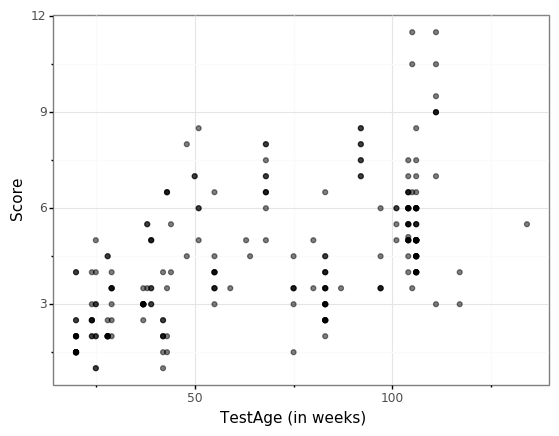

<ggplot: (303792733)>

In [5]:
(ggplot(df4, aes(x = 'TestAge', y = 'score')) + geom_point(alpha = 0.5) + labs(x = 'TestAge (in weeks)', y = 'Score') + theme_bw())

In [13]:
df3.head()

,score,Sex,avg_angular_velocity,avg_base_tail_lateral_displacement,avg_limb_duty_factor,avg_nose_lateral_displacement,avg_speed_cm_per_sec,avg_step_length1,avg_step_length2,avg_step_width,...,grooming_duration_secs,dAC_mean,dB_mean,aABC_mean,dAC_stdev,dB_stdev,aABC_stdev,median_rearpaw,median_width,median_length
0,6.5,-1,-2.327184,0.167058,0.573905,0.154335,15.789958,1.463622,2.981784,2.925360,...,189.58934,0.720076,4.875092,157.085273,0.130175,3.997429,24.811439,26.076810,37.309433,68.151154
1,8.5,-1,1.679655,0.143185,0.508349,0.111054,13.739694,2.448495,2.195100,3.267907,...,44.41103,0.695964,4.379226,160.580613,0.114058,2.944559,17.221584,30.083218,39.790108,68.401505
2,8.0,1,2.135921,0.208733,0.568509,0.156425,18.419089,2.490609,2.616260,3.092184,...,88.82207,0.723106,4.041541,161.989204,0.109981,3.077493,18.561834,26.000000,34.155231,67.100876
3,6.0,1,0.539645,0.171272,0.527716,0.135206,13.615276,2.209762,2.501505,3.501622,...,101.86843,0.702753,4.847020,159.682380,0.109922,3.325404,18.259767,32.062439,41.796808,64.817986
4,8.5,1,-7.125473,0.213399,0.617378,0.174713,17.148463,2.217612,2.464234,2.865290,...,80.48033,0.707546,3.610924,162.702636,0.117465,2.346359,15.482651,24.698178,32.395500,63.395126


In [14]:
df3.shape

(252, 63)

In [16]:
df3['Sex'] = df3['Sex'].apply(lambda x: 0 if x == -1 else x)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
